In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'lib')
from lib.read_data import *

In [17]:
path = "data/dambreak_N128_200"
frame = 113
num_ritz = 100

A = readA_sparse(f"{path}/A_{frame}.bin").astype(np.float32)
rhs = load_vector(f"{path}/div_v_star_{frame}.bin").astype(np.float32)
flags = read_flags(f"{path}/flags_{frame}.bin")
ritz_vecs = np.memmap(f"{path}/preprocessed/{frame}/ritz_{num_ritz}.dat", dtype=np.float32, mode='r').reshape(num_ritz, -1)

In [18]:
A_comp = compressedMat(A, flags)
A_comp.shape

(379, 379)

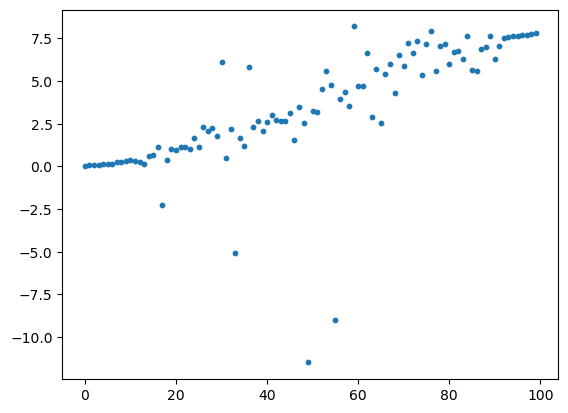

In [19]:
eigs = A_comp @ ritz_vecs.T / ritz_vecs.T
plt.scatter(range(len(eigs[0])), eigs[0], s=10);

In [20]:
rhs_comp = compressedVec(rhs, flags)
coeffs = ritz_vecs @ rhs_comp
rhs_left = rhs_comp - coeffs @ ritz_vecs
np.linalg.norm(rhs_left)/np.linalg.norm(rhs_comp)

1.3995317e-07

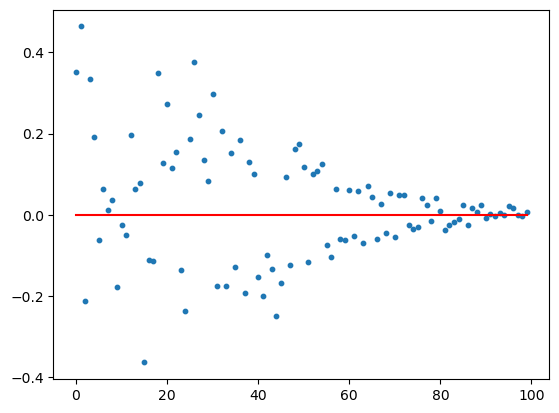

In [21]:
plt.plot(np.zeros(len(coeffs)), c='r')
plt.scatter(range(len(coeffs)), coeffs, s=10);

In [15]:
for i in range(17):
# i = 1
    r = np.load(f"res_{i}.npy")
    r_comp = compressedVec(r, flags)
    coeffs_r = ritz_vecs @ r_comp
    print(np.linalg.norm(coeffs_r), end=', ')
    r_left = r_comp - coeffs @ ritz_vecs
    left_norm = np.linalg.norm(r_left)/np.linalg.norm(r_comp)
    print(left_norm)
    # plt.plot(np.zeros(len(coeffs_r)), c='r')
    # plt.scatter(range(len(coeffs_r)), coeffs_r, s=10)

FileNotFoundError: [Errno 2] No such file or directory: 'res_0.npy'